In [26]:
import xarray as xr
import dask.array as da
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs

- Filter out the ocean 
- Aggregate dead fuel moisture over LA county 
- Plot time series with mean wind speed (2 data sets of wind) 
- Sensitivity analysis of DFM to windspeed 
- ERA5 dead fuel moisture to John air fuel moisture

For both 2011 and 2025 events

In [27]:
import os
DATA_DIR = "/home/mitch/data/geog256"
os.listdir(DATA_DIR)

['dfmc_realigned.zarr',
 'era5_derived_hourly.zarr',
 'era5_daily.tar.gz',
 'era5_landsea_mask.grib',
 'era5_hourly.tar.gz',
 'dfmc.tar.gz',
 'era5_los_angeles.zarr',
 'era5_derived_daily.zarr',
 'dfmc_input.zarr',
 'dfmc.zarr',
 'era5_landsea_mask.grib.5b7b6.idx']

In [28]:
T_FILTER_2025 = slice("2025-01-01", "2025-01-11")
T_FILTER_2011 = slice("2011-11-25", "2011-12-05")

LA_BOUNDING_BOX = {
    "lat_min": 33.5,  # Southernmost point
    "lat_max": 34.8,  # Northernmost point
    "lon_min": -119.0, # Westernmost point
    "lon_max": -117.5  # Easternmost point
}

def filter_dataset_by_bbox(ds, lat_min, lat_max, lon_min, lon_max):
    return ds.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))

def convert_longitude(ds):
    ds = ds.assign_coords(longitude=((ds["longitude"] + 180) % 360 - 180)) 
    ds = ds.sortby("longitude")  
    ds = ds.sortby("latitude")
    return ds

def apply_custom_mask(ds):
    exclude_coords = [
        (33.78, -118.9),
        (33.53, -118.9),
        (33.78, -118.65),
        (33.53, -118.65),
        (33.53, -118.4),
        (33.53, -118.15),
        (33.53, -117.9),
    ]
    for lat, lon in exclude_coords:
        ds = ds.where(~((ds.latitude == lat) & (ds.longitude == lon)), drop=True)
    return ds

### Mask for land

In [29]:
lat_era5 = np.arange(-90, 90.25, 0.25)
lon_era5 = np.arange(-180, 180.25, 0.25)

dfmc_ds = xr.open_dataset(f"{DATA_DIR}/dfmc.zarr", chunks="auto")
dfmc_ds = filter_dataset_by_bbox(
    dfmc_ds,
    **LA_BOUNDING_BOX,
)
dfmc_ds = apply_custom_mask(dfmc_ds)
dfmc_ds


<xarray.Dataset> Size: 16MB
Dimensions:     (valid_time: 27042, latitude: 6, longitude: 6)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 216kB 1951-01-01 ... 2025-01-13
  * latitude    (latitude) float64 48B 33.53 33.78 34.03 34.28 34.53 34.78
  * longitude   (longitude) float64 48B -118.9 -118.7 -118.4 ... -117.9 -117.7
Data variables:
    fm1000      (valid_time, latitude, longitude) float64 8MB dask.array<chunksize=(20286, 6, 6), meta=np.ndarray>
    fm100       (valid_time, latitude, longitude) float64 8MB dask.array<chunksize=(20286, 6, 6), meta=np.ndarray>

In [30]:
era5_ds = xr.open_dataset(f"{DATA_DIR}/era5_los_angeles.zarr", chunks="auto").sortby("latitude")
era5_ds = filter_dataset_by_bbox(
    era5_ds,
    **LA_BOUNDING_BOX,
)
era5_ds = apply_custom_mask(era5_ds)
era5_ds = (
    era5_ds
    .assign(
        wind=lambda ds: da.hypot(ds.u10, ds.v10),
        rh=lambda ds: 100 * da.exp((17.625 * (ds.d2m - ds.t2m)) / (243.04 + (ds.d2m - ds.t2m)))
    )
)
wind_mean = era5_ds["wind"].resample(valid_time="1D").mean()
wind_max = era5_ds["wind"].resample(valid_time="1D").max()
precip = era5_ds["tp"].resample(valid_time="1D").sum()
rh = era5_ds["rh"].resample(valid_time="1D").mean()

e5_daily_ds = xr.Dataset({
    "wind_mean": wind_mean,
    "wind_max": wind_max,
    "precip": precip,
    "rh": rh,
})
e5_daily_ds

<xarray.Dataset> Size: 16MB
Dimensions:     (latitude: 6, longitude: 6, valid_time: 27042)
Coordinates:
  * latitude    (latitude) float64 48B 33.53 33.78 34.03 34.28 34.53 34.78
  * longitude   (longitude) float64 48B -118.9 -118.7 -118.4 ... -117.9 -117.7
  * valid_time  (valid_time) datetime64[ns] 216kB 1951-01-01 ... 2025-01-13
Data variables:
    wind_mean   (valid_time, latitude, longitude) float32 4MB dask.array<chunksize=(1792, 6, 6), meta=np.ndarray>
    wind_max    (valid_time, latitude, longitude) float32 4MB dask.array<chunksize=(1792, 6, 6), meta=np.ndarray>
    precip      (valid_time, latitude, longitude) float32 4MB dask.array<chunksize=(1792, 6, 6), meta=np.ndarray>
    rh          (valid_time, latitude, longitude) float32 4MB dask.array<chunksize=(1792, 6, 6), meta=np.ndarray>

## DFMC Rasters

### 2025 DFMC anomaly

In [6]:
dfmc_ds_2025_clim_mean = (
    dfmc_ds.sel(valid_time=slice("1950-01-01", "2010-12-31")).mean(dim="valid_time")
    .rename({"fm100": "fm100_mean", "fm1000": "fm1000_mean"})
)

dfmc_ds_2025 = (
    dfmc_ds.sel(valid_time=T_FILTER_2025).merge(dfmc_ds_2025_clim_mean)
    .assign(
        fm100_anomaly=lambda ds: ds.fm100 - ds.fm100_mean,
        fm1000_anomaly=lambda ds: ds.fm1000 - ds.fm1000_mean,
    )
)
dfmc_ds_2025

<xarray.Dataset> Size: 13kB
Dimensions:         (valid_time: 11, latitude: 6, longitude: 6)
Coordinates:
  * valid_time      (valid_time) datetime64[ns] 88B 2025-01-01 ... 2025-01-11
  * latitude        (latitude) float64 48B 33.53 33.78 34.03 34.28 34.53 34.78
  * longitude       (longitude) float64 48B -118.9 -118.7 ... -117.9 -117.7
Data variables:
    fm1000          (valid_time, latitude, longitude) float64 3kB dask.array<chunksize=(11, 6, 6), meta=np.ndarray>
    fm100           (valid_time, latitude, longitude) float64 3kB dask.array<chunksize=(11, 6, 6), meta=np.ndarray>
    fm1000_mean     (latitude, longitude) float64 288B dask.array<chunksize=(6, 6), meta=np.ndarray>
    fm100_mean      (latitude, longitude) float64 288B dask.array<chunksize=(6, 6), meta=np.ndarray>
    fm100_anomaly   (valid_time, latitude, longitude) float64 3kB dask.array<chunksize=(11, 6, 6), meta=np.ndarray>
    fm1000_anomaly  (valid_time, latitude, longitude) float64 3kB dask.array<chunksize=(11, 6, 6), meta=np.ndarray>

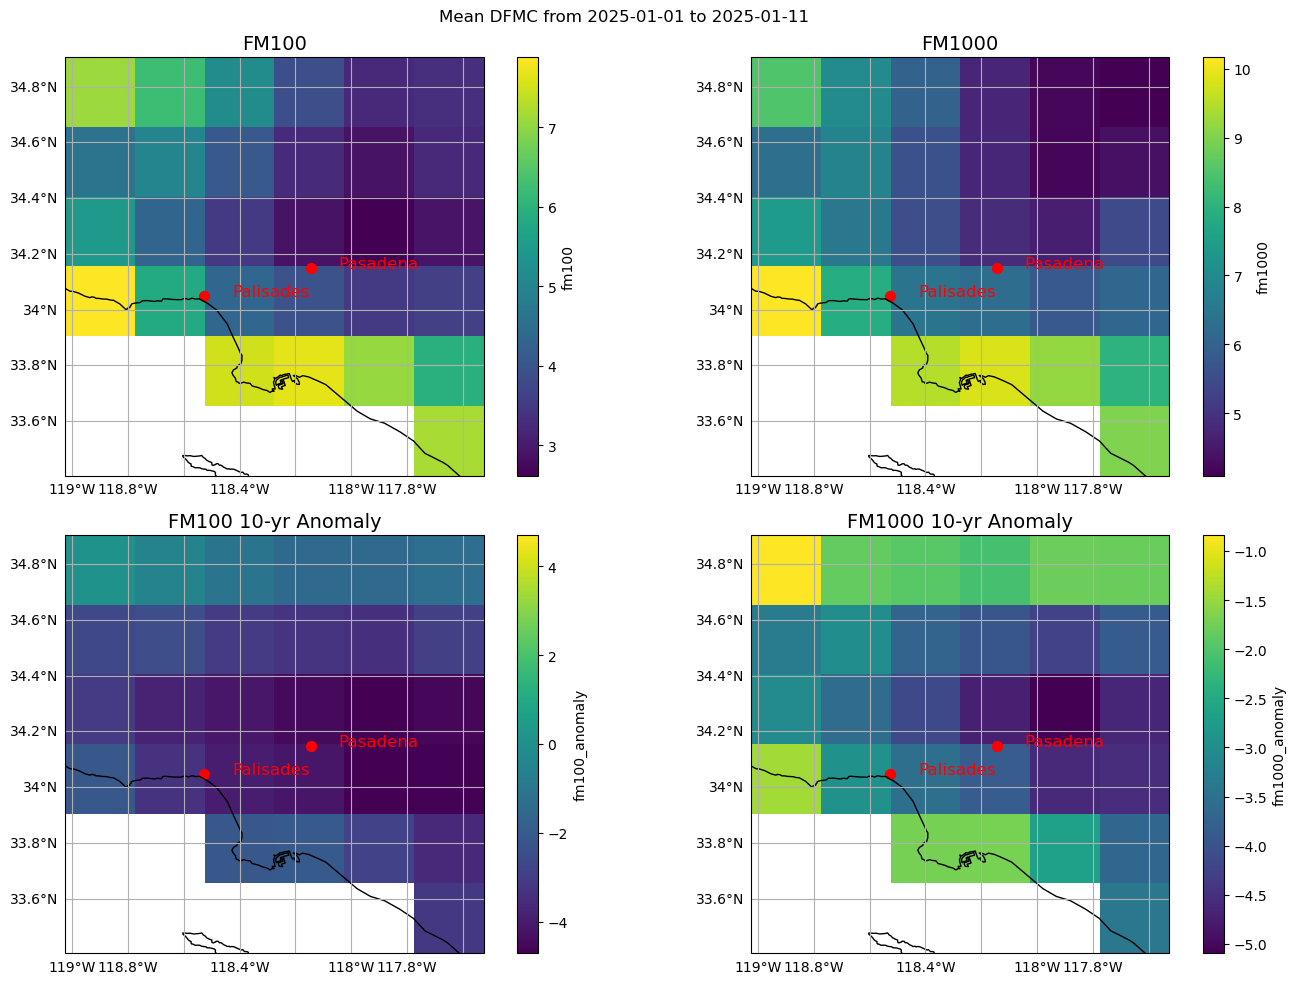

In [7]:
# Coordinates for Palisades and Pasadena
locations = {
    "Palisades": (34.0486, -118.5268),  
    "Pasadena": (34.1478, -118.1445)    
}

# Define variables and titles
variables = ["fm100", "fm1000", "fm100_anomaly", "fm1000_anomaly"]
titles = ["FM100", "FM1000", "FM100 10-yr Anomaly", "FM1000 10-yr Anomaly"]

# Create figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10), subplot_kw={"projection": ccrs.PlateCarree()})

# Loop through variables and plot them in the 2x2 grid
for ax, var, title in zip(axes.flat, variables, titles):
    dfmc_ds_2025[var].mean(dim="valid_time").plot(ax=ax, cmap="viridis")  # Adjust colormap if needed
    ax.coastlines()

    # Disable top & right latitude/longitude ticks
    gl = ax.gridlines(draw_labels=True)
    gl.right_labels = False
    gl.top_labels = False

    # Add city markers
    for city, (lat, lon) in locations.items():
        ax.scatter(lon, lat, color="red", s=50, marker="o", transform=ccrs.PlateCarree(), label=city)
        ax.text(lon + 0.1, lat, city, fontsize=12, color="red", transform=ccrs.PlateCarree())

    ax.set_title(title, fontsize=14)
    
plt.suptitle("Mean DFMC from 2025-01-01 to 2025-01-11")
plt.tight_layout()
plt.show()


### 2011 DFMC anomaly

In [8]:
dfmc_ds_2011_clim_mean = (
    dfmc_ds.sel(valid_time=slice("1950-01-01", "2010-12-31")).mean(dim="valid_time")
    .rename({"fm100": "fm100_mean", "fm1000": "fm1000_mean"})
)

dfmc_ds_2011 = (
    dfmc_ds.sel(valid_time=T_FILTER_2011).merge(dfmc_ds_2011_clim_mean)
    .assign(
        fm100_anomaly=lambda ds: ds.fm100 - ds.fm100_mean,
        fm1000_anomaly=lambda ds: ds.fm1000 - ds.fm1000_mean,
    )
)
dfmc_ds_2011

<xarray.Dataset> Size: 13kB
Dimensions:         (valid_time: 11, latitude: 6, longitude: 6)
Coordinates:
  * valid_time      (valid_time) datetime64[ns] 88B 2011-11-25 ... 2011-12-05
  * latitude        (latitude) float64 48B 33.53 33.78 34.03 34.28 34.53 34.78
  * longitude       (longitude) float64 48B -118.9 -118.7 ... -117.9 -117.7
Data variables:
    fm1000          (valid_time, latitude, longitude) float64 3kB dask.array<chunksize=(11, 6, 6), meta=np.ndarray>
    fm100           (valid_time, latitude, longitude) float64 3kB dask.array<chunksize=(11, 6, 6), meta=np.ndarray>
    fm1000_mean     (latitude, longitude) float64 288B dask.array<chunksize=(6, 6), meta=np.ndarray>
    fm100_mean      (latitude, longitude) float64 288B dask.array<chunksize=(6, 6), meta=np.ndarray>
    fm100_anomaly   (valid_time, latitude, longitude) float64 3kB dask.array<chunksize=(11, 6, 6), meta=np.ndarray>
    fm1000_anomaly  (valid_time, latitude, longitude) float64 3kB dask.array<chunksize=(11, 6, 6), meta=np.ndarray>

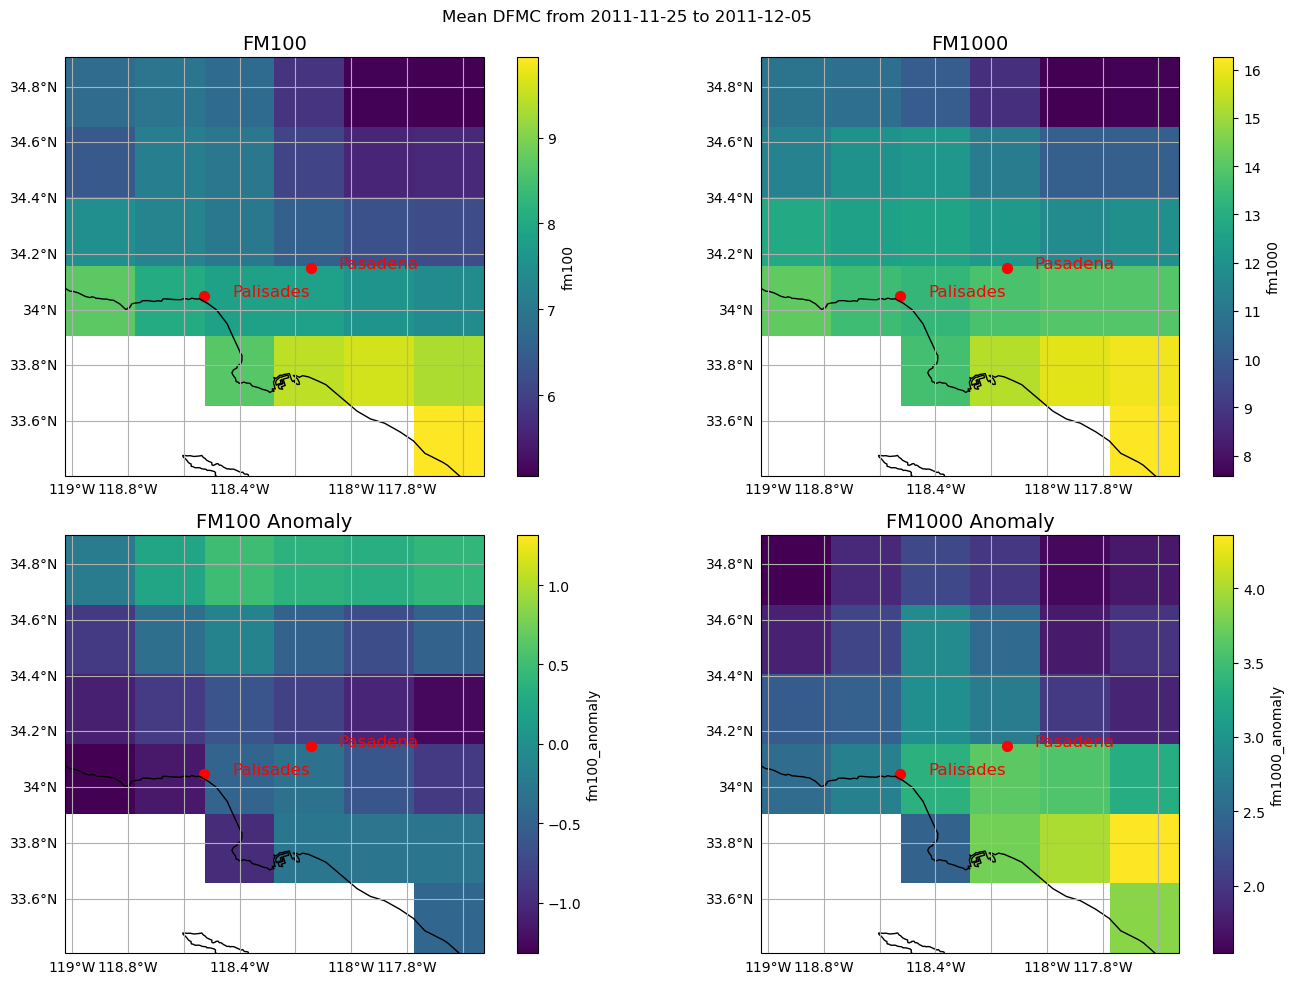

In [9]:
# Coordinates for Palisades and Pasadena
locations = {
    "Palisades": (34.0486, -118.5268),  
    "Pasadena": (34.1478, -118.1445)    
}

variables = ["fm100", "fm1000", "fm100_anomaly", "fm1000_anomaly"]
titles = ["FM100", "FM1000", "FM100 Anomaly", "FM1000 Anomaly"]

fig, axes = plt.subplots(2, 2, figsize=(14, 10), subplot_kw={"projection": ccrs.PlateCarree()})
for ax, var, title in zip(axes.flat, variables, titles):
    dfmc_ds_2011[var].mean(dim="valid_time").plot(ax=ax, cmap="viridis") 
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True)
    gl.right_labels = False
    gl.top_labels = False

    for city, (lat, lon) in locations.items():
        ax.scatter(lon, lat, color="red", s=50, marker="o", transform=ccrs.PlateCarree(), label=city)
        ax.text(lon + 0.1, lat, city, fontsize=12, color="red", transform=ccrs.PlateCarree())

    ax.set_title(title, fontsize=14)

plt.suptitle("Mean DFMC from 2011-11-25 to 2011-12-05")
plt.tight_layout()
plt.show()


## DFMC time series

In [15]:
ts_dfmc_ds_2011_clim_mean = (
    dfmc_ds.sel(valid_time=slice("1950-01-01", "2010-12-31")).mean(dim="valid_time")
    .rename({"fm100": "fm100_mean", "fm1000": "fm1000_mean"})
)

ts_dfmc_ds_2011 = (
    dfmc_ds.sel(valid_time=slice("2011-09-01", "2012-01-01")).merge(dfmc_ds_2011_clim_mean)
    .assign(
        fm100_anomaly=lambda ds: ds.fm100 - ds.fm100_mean,
        fm1000_anomaly=lambda ds: ds.fm1000 - ds.fm1000_mean,
    )
)
ts_dfmc_ds_2011

<xarray.Dataset> Size: 143kB
Dimensions:         (valid_time: 123, latitude: 6, longitude: 6)
Coordinates:
  * valid_time      (valid_time) datetime64[ns] 984B 2011-09-01 ... 2012-01-01
  * latitude        (latitude) float64 48B 33.53 33.78 34.03 34.28 34.53 34.78
  * longitude       (longitude) float64 48B -118.9 -118.7 ... -117.9 -117.7
Data variables:
    fm1000          (valid_time, latitude, longitude) float64 35kB dask.array<chunksize=(123, 6, 6), meta=np.ndarray>
    fm100           (valid_time, latitude, longitude) float64 35kB dask.array<chunksize=(123, 6, 6), meta=np.ndarray>
    fm1000_mean     (latitude, longitude) float64 288B dask.array<chunksize=(6, 6), meta=np.ndarray>
    fm100_mean      (latitude, longitude) float64 288B dask.array<chunksize=(6, 6), meta=np.ndarray>
    fm100_anomaly   (valid_time, latitude, longitude) float64 35kB dask.array<chunksize=(123, 6, 6), meta=np.ndarray>
    fm1000_anomaly  (valid_time, latitude, longitude) float64 35kB dask.array<chunksize=(123, 6, 6), meta=np.ndarray>

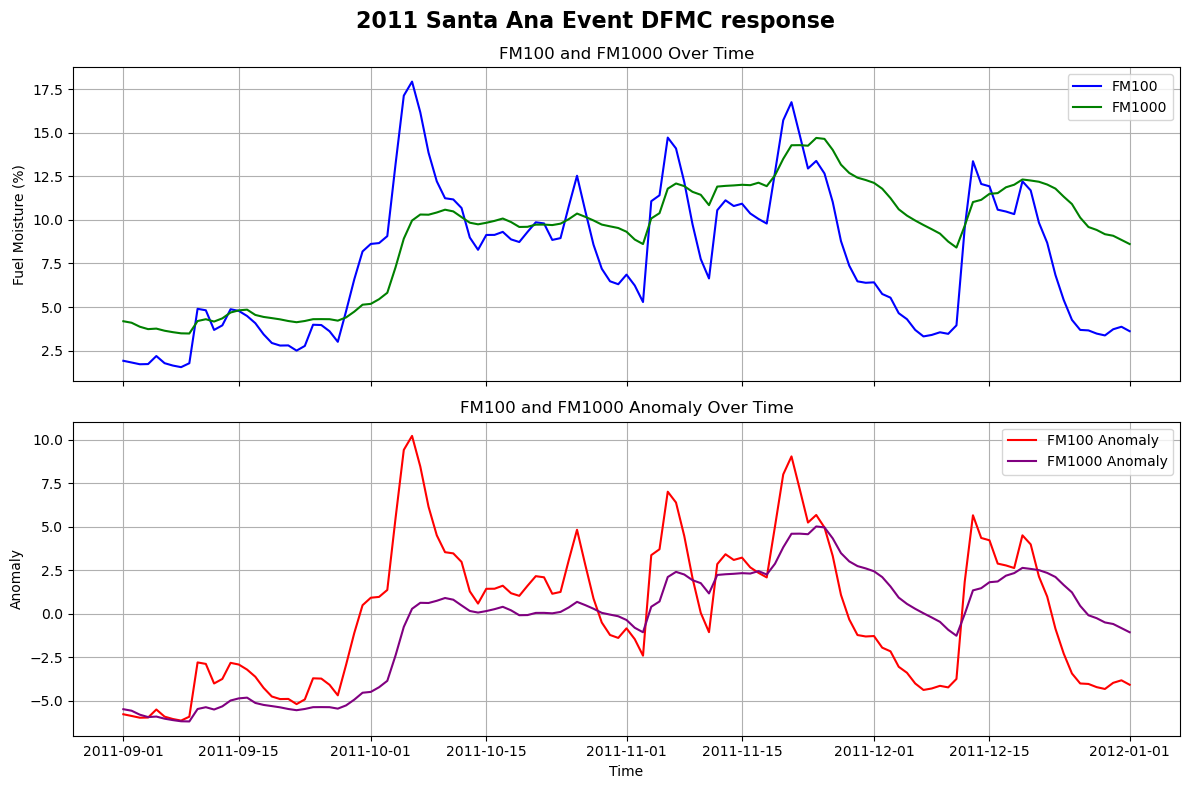

In [16]:
# Compute mean across all grid cells (latitude, longitude) per time step
ts_fm100_mean = ts_dfmc_ds_2011.fm100.mean(dim=["latitude", "longitude"])
ts_fm1000_mean = ts_dfmc_ds_2011.fm1000.mean(dim=["latitude", "longitude"])
ts_fm100_anom_mean = ts_dfmc_ds_2011.fm100_anomaly.mean(dim=["latitude", "longitude"])
ts_fm1000_anom_mean = ts_dfmc_ds_2011.fm1000_anomaly.mean(dim=["latitude", "longitude"])

# Create figure with 1x2 layout
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# **Top Plot: FM100 and FM1000 Mean**
axes[0].plot(ts_fm100_mean.valid_time, ts_fm100_mean, label="FM100", color="blue")
axes[0].plot(ts_fm1000_mean.valid_time, ts_fm1000_mean, label="FM1000", color="green")
axes[0].set_title("FM100 and FM1000 Over Time")
axes[0].set_ylabel("Fuel Moisture (%)")
axes[0].legend()
axes[0].grid()

# **Bottom Plot: FM100 Anomaly and FM1000 Anomaly Mean**
axes[1].plot(ts_fm100_anom_mean.valid_time, ts_fm100_anom_mean, label="FM100 Anomaly", color="red")
axes[1].plot(ts_fm1000_anom_mean.valid_time, ts_fm1000_anom_mean, label="FM1000 Anomaly", color="purple")
axes[1].set_title("FM100 and FM1000 Anomaly Over Time")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Anomaly")
axes[1].legend()
axes[1].grid()

# Adjust layout
plt.suptitle("2011 Santa Ana Event DFMC response", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()


In [17]:
ts_dfmc_ds_2025_clim_mean = (
    dfmc_ds.sel(valid_time=slice("1950-01-01", "2010-12-31")).mean(dim="valid_time")
    .rename({"fm100": "fm100_mean", "fm1000": "fm1000_mean"})
)

ts_dfmc_ds_2025 = (
    dfmc_ds.sel(valid_time=slice("2024-10-13", "2025-01-13")).merge(dfmc_ds_2011_clim_mean)
    .assign(
        fm100_anomaly=lambda ds: ds.fm100 - ds.fm100_mean,
        fm1000_anomaly=lambda ds: ds.fm1000 - ds.fm1000_mean,
    )
)
ts_dfmc_ds_2025

<xarray.Dataset> Size: 109kB
Dimensions:         (valid_time: 93, latitude: 6, longitude: 6)
Coordinates:
  * valid_time      (valid_time) datetime64[ns] 744B 2024-10-13 ... 2025-01-13
  * latitude        (latitude) float64 48B 33.53 33.78 34.03 34.28 34.53 34.78
  * longitude       (longitude) float64 48B -118.9 -118.7 ... -117.9 -117.7
Data variables:
    fm1000          (valid_time, latitude, longitude) float64 27kB dask.array<chunksize=(93, 6, 6), meta=np.ndarray>
    fm100           (valid_time, latitude, longitude) float64 27kB dask.array<chunksize=(93, 6, 6), meta=np.ndarray>
    fm1000_mean     (latitude, longitude) float64 288B dask.array<chunksize=(6, 6), meta=np.ndarray>
    fm100_mean      (latitude, longitude) float64 288B dask.array<chunksize=(6, 6), meta=np.ndarray>
    fm100_anomaly   (valid_time, latitude, longitude) float64 27kB dask.array<chunksize=(93, 6, 6), meta=np.ndarray>
    fm1000_anomaly  (valid_time, latitude, longitude) float64 27kB dask.array<chunksize=(93, 6, 6), meta=np.ndarray>

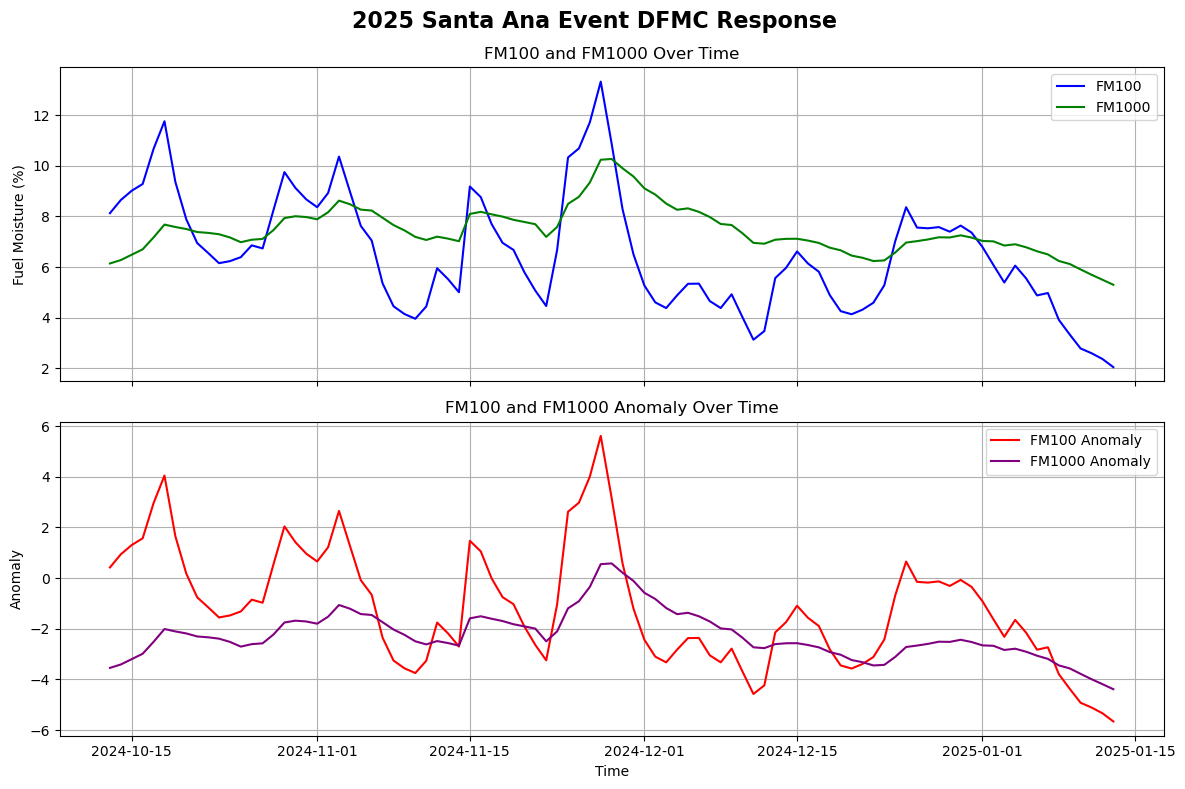

In [18]:
# Compute mean across all grid cells (latitude, longitude) per time step for 2025
ts_fm100_mean = ts_dfmc_ds_2025.fm100.mean(dim=["latitude", "longitude"])
ts_fm1000_mean = ts_dfmc_ds_2025.fm1000.mean(dim=["latitude", "longitude"])
ts_fm100_anom_mean = ts_dfmc_ds_2025.fm100_anomaly.mean(dim=["latitude", "longitude"])
ts_fm1000_anom_mean = ts_dfmc_ds_2025.fm1000_anomaly.mean(dim=["latitude", "longitude"])

# Create figure with 1x2 layout
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# **Top Plot: FM100 and FM1000 Mean**
axes[0].plot(ts_fm100_mean.valid_time, ts_fm100_mean, label="FM100", color="blue")
axes[0].plot(ts_fm1000_mean.valid_time, ts_fm1000_mean, label="FM1000", color="green")
axes[0].set_title("FM100 and FM1000 Over Time")
axes[0].set_ylabel("Fuel Moisture (%)")
axes[0].legend()
axes[0].grid()

# **Bottom Plot: FM100 Anomaly and FM1000 Anomaly Mean**
axes[1].plot(ts_fm100_anom_mean.valid_time, ts_fm100_anom_mean, label="FM100 Anomaly", color="red")
axes[1].plot(ts_fm1000_anom_mean.valid_time, ts_fm1000_anom_mean, label="FM1000 Anomaly", color="purple")
axes[1].set_title("FM100 and FM1000 Anomaly Over Time")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Anomaly")
axes[1].legend()
axes[1].grid()

# Adjust layout
plt.suptitle("2025 Santa Ana Event DFMC Response", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()


# DFMC Histogram

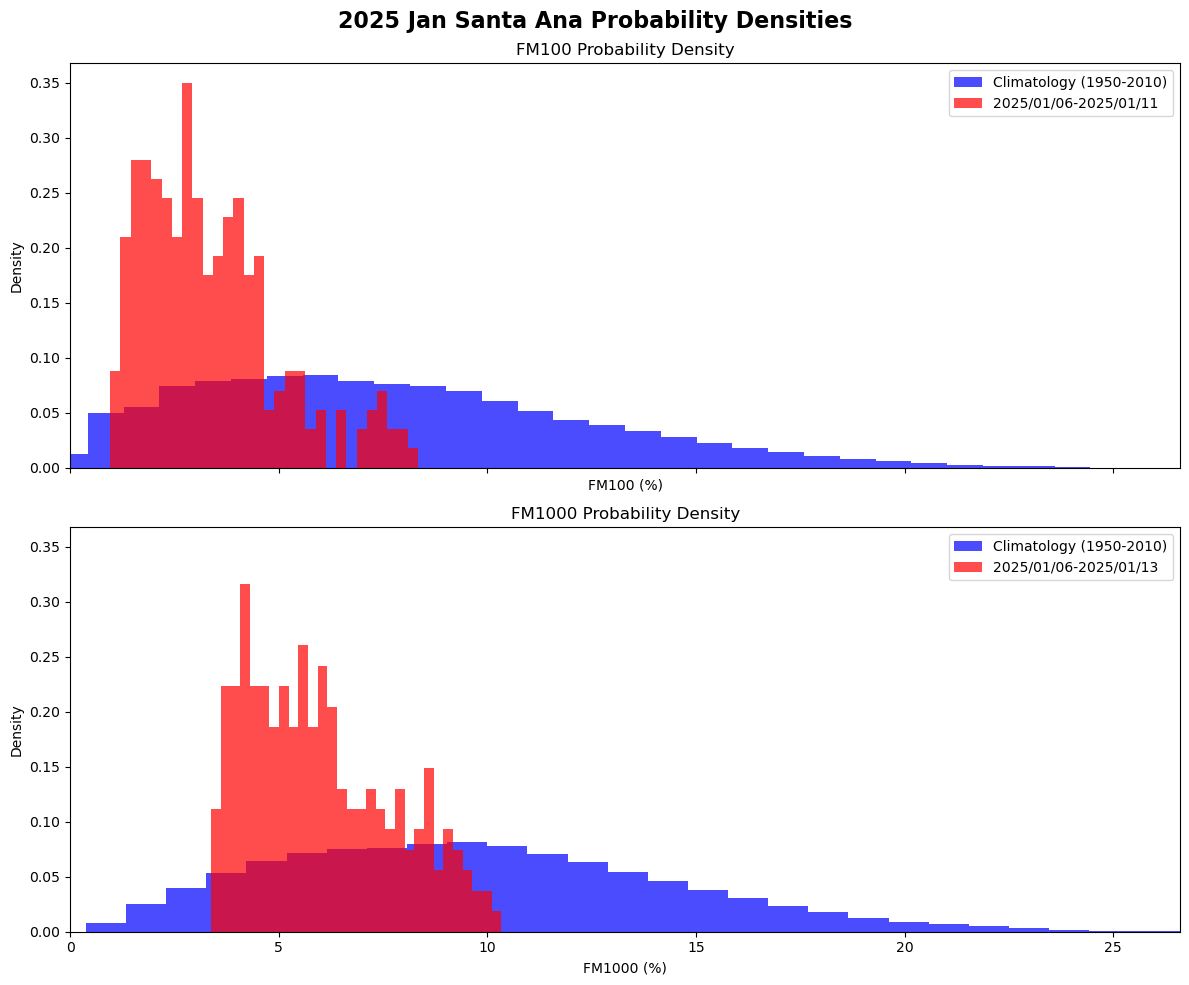

In [21]:
# Flatten the data arrays for histogram plotting
fm100_clim = dfmc_ds.sel(valid_time=slice("1950-01-01", "2010-12-31")).fm100.values.flatten()
fm100_event = ts_dfmc_ds_2025.sel(valid_time=slice("2025-01-06", "2025-01-13")).fm100.values.flatten()
fm1000_clim = dfmc_ds.sel(valid_time=slice("1950-01-01", "2010-12-31")).fm1000.values.flatten()
fm1000_event = ts_dfmc_ds_2025.sel(valid_time=slice("2025-01-06", "2025-01-13")).fm1000.values.flatten()

# Define figure with 2x1 grid (stacked layout)
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True, sharey=True)

# Common bin size and x-axis limits
bins = 30  
xlim_min = 0  # Set x-axis to start at 0

# **Top Plot: FM100 Probability Density**
axes[0].hist(fm100_clim, bins=bins, alpha=0.7, label="Climatology (1950-2010)", color="blue", density=True)
axes[0].hist(fm100_event, bins=bins, alpha=0.7, label="2025/01/06-2025/01/11", color="red", density=True)
axes[0].set_title("FM100 Probability Density")
axes[0].set_xlabel("FM100 (%)")
axes[0].set_ylabel("Density")
axes[0].set_xlim(left=xlim_min)  # Ensure x-axis starts at 0
axes[0].legend()

# **Bottom Plot: FM1000 Probability Density**
axes[1].hist(fm1000_clim, bins=bins, alpha=0.7, label="Climatology (1950-2010)", color="blue", density=True)
axes[1].hist(fm1000_event, bins=bins, alpha=0.7, label="2025/01/06-2025/01/13", color="red", density=True)
axes[1].set_title("FM1000 Probability Density")
axes[1].set_xlabel("FM1000 (%)")
axes[1].set_ylabel("Density")
axes[1].set_xlim(left=xlim_min)  # Ensure x-axis starts at 0
axes[1].legend()

# Adjust layout
plt.suptitle("2025 Jan Santa Ana Probability Densities", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()


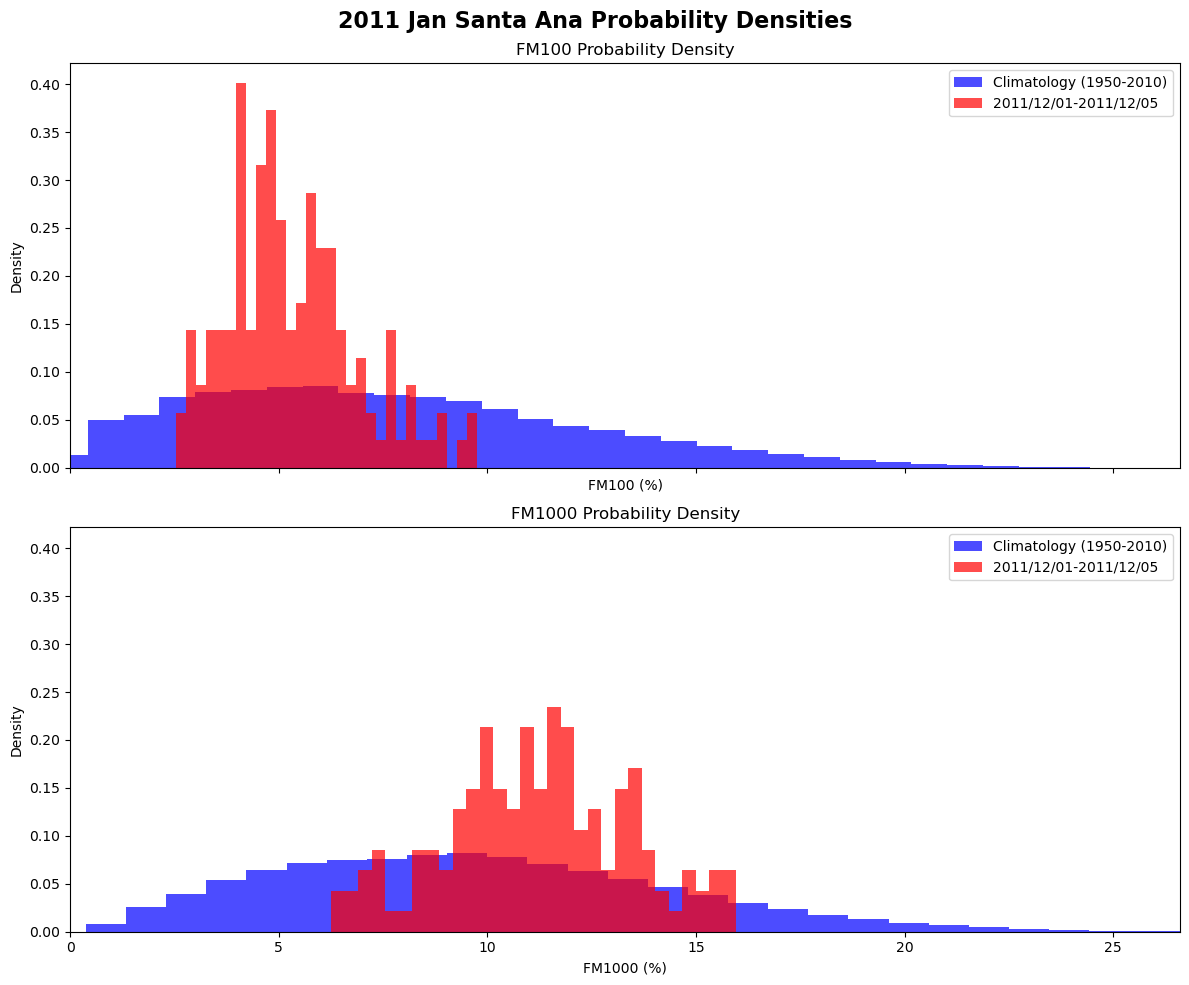

In [22]:
import matplotlib.pyplot as plt

# Flatten the data arrays for histogram plotting
fm100_clim = dfmc_ds.sel(valid_time=slice("1950-01-01", "2010-12-31")).fm100.values.flatten()
fm100_event = ts_dfmc_ds_2011.sel(valid_time=slice("2011-12-01", "2011-12-05")).fm100.values.flatten()
fm1000_clim = dfmc_ds.sel(valid_time=slice("1950-01-01", "2010-12-31")).fm1000.values.flatten()
fm1000_event = ts_dfmc_ds_2011.sel(valid_time=slice("2011-12-01", "2011-12-05")).fm1000.values.flatten()

# Define figure with 2x1 grid (stacked layout)
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True, sharey=True)

# Common bin size and x-axis limits
bins = 30  
xlim_min = 0  # Set x-axis to start at 0

# **Top Plot: FM100 Probability Density**
axes[0].hist(fm100_clim, bins=bins, alpha=0.7, label="Climatology (1950-2010)", color="blue", density=True)
axes[0].hist(fm100_event, bins=bins, alpha=0.7, label="2011/12/01-2011/12/05", color="red", density=True)
axes[0].set_title("FM100 Probability Density")
axes[0].set_xlabel("FM100 (%)")
axes[0].set_ylabel("Density")
axes[0].set_xlim(left=xlim_min)  # Ensure x-axis starts at 0
axes[0].legend()

# **Bottom Plot: FM1000 Probability Density**
axes[1].hist(fm1000_clim, bins=bins, alpha=0.7, label="Climatology (1950-2010)", color="blue", density=True)
axes[1].hist(fm1000_event, bins=bins, alpha=0.7, label="2011/12/01-2011/12/05", color="red", density=True)
axes[1].set_title("FM1000 Probability Density")
axes[1].set_xlabel("FM1000 (%)")
axes[1].set_ylabel("Density")
axes[1].set_xlim(left=xlim_min)  # Ensure x-axis starts at 0
axes[1].legend()

# Adjust layout
plt.suptitle("2011 Jan Santa Ana Probability Densities", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()


# Weather vs DFMC

In [31]:
weather_ds = xr.merge([dfmc_ds, e5_daily_ds])
weather_ds

<xarray.Dataset> Size: 31MB
Dimensions:     (valid_time: 27042, latitude: 6, longitude: 6)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 216kB 1951-01-01 ... 2025-01-13
  * latitude    (latitude) float64 48B 33.53 33.78 34.03 34.28 34.53 34.78
  * longitude   (longitude) float64 48B -118.9 -118.7 -118.4 ... -117.9 -117.7
Data variables:
    fm1000      (valid_time, latitude, longitude) float64 8MB dask.array<chunksize=(20286, 6, 6), meta=np.ndarray>
    fm100       (valid_time, latitude, longitude) float64 8MB dask.array<chunksize=(20286, 6, 6), meta=np.ndarray>
    wind_mean   (valid_time, latitude, longitude) float32 4MB dask.array<chunksize=(1792, 6, 6), meta=np.ndarray>
    wind_max    (valid_time, latitude, longitude) float32 4MB dask.array<chunksize=(1792, 6, 6), meta=np.ndarray>
    precip      (valid_time, latitude, longitude) float32 4MB dask.array<chunksize=(1792, 6, 6), meta=np.ndarray>
    rh          (valid_time, latitude, longitude) float32 4MB dask.array<chunksize=(1792, 6, 6), meta=np.ndarray>

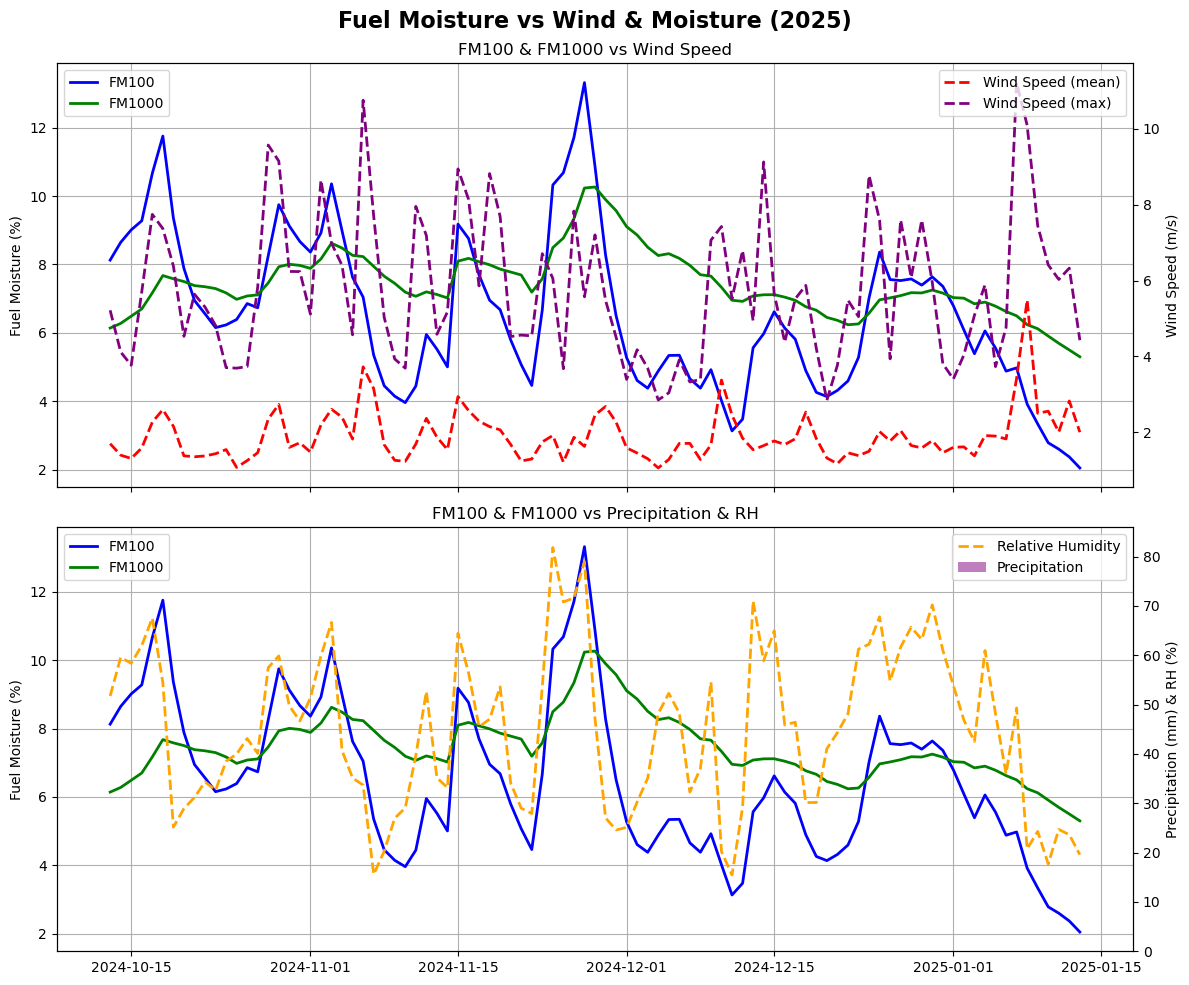

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Select time range
filtered_df = weather_ds.sel(valid_time=slice("2024-10-13", "2025-01-13"))

# Extract variables
time = filtered_df.valid_time
fm100 = filtered_df.fm100.mean(dim=["latitude", "longitude"])
fm1000 = filtered_df.fm1000.mean(dim=["latitude", "longitude"])
wind = filtered_df.wind_mean.mean(dim=["latitude", "longitude"])
wind_max = filtered_df.wind_max.max(dim=["latitude", "longitude"])
precip = filtered_df.precip.mean(dim=["latitude", "longitude"])
rh = filtered_df.rh.mean(dim=["latitude", "longitude"])  # Extract RH directly

# Create figure with 2 subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# **Top Chart: FM100 & FM1000 vs. Wind Speed**
ax1 = axes[0]
ax2 = ax1.twinx()  # Create secondary y-axis

ax1.plot(time, fm100, label="FM100", color="blue", linewidth=2)
ax1.plot(time, fm1000, label="FM1000", color="green", linewidth=2)
ax2.plot(time, wind, label="Wind Speed (mean)", color="red", linestyle="dashed", linewidth=2)
ax2.plot(time, wind_max, label="Wind Speed (max)", color="purple", linestyle="dashed", linewidth=2)

ax1.set_ylabel("Fuel Moisture (%)")
ax2.set_ylabel("Wind Speed (m/s)")
ax1.set_title("FM100 & FM1000 vs Wind Speed")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
ax1.grid()

# **Bottom Chart: FM100 & FM1000 vs. Precipitation & RH**
ax3 = axes[1]
ax4 = ax3.twinx()  # Create secondary y-axis

ax3.plot(time, fm100, label="FM100", color="blue", linewidth=2)
ax3.plot(time, fm1000, label="FM1000", color="green", linewidth=2)
ax4.bar(time, precip, label="Precipitation", color="purple", alpha=0.5, width=0.8)
ax4.plot(time, rh, label="Relative Humidity", color="orange", linestyle="dashed", linewidth=2)  # Add RH line

ax3.set_ylabel("Fuel Moisture (%)")
ax4.set_ylabel("Precipitation (mm) & RH (%)")
ax3.set_title("FM100 & FM1000 vs Precipitation & RH")
ax3.legend(loc="upper left")
ax4.legend(loc="upper right")
ax3.grid()

# Adjust layout
plt.suptitle("Fuel Moisture vs Wind & Moisture (2025)", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()


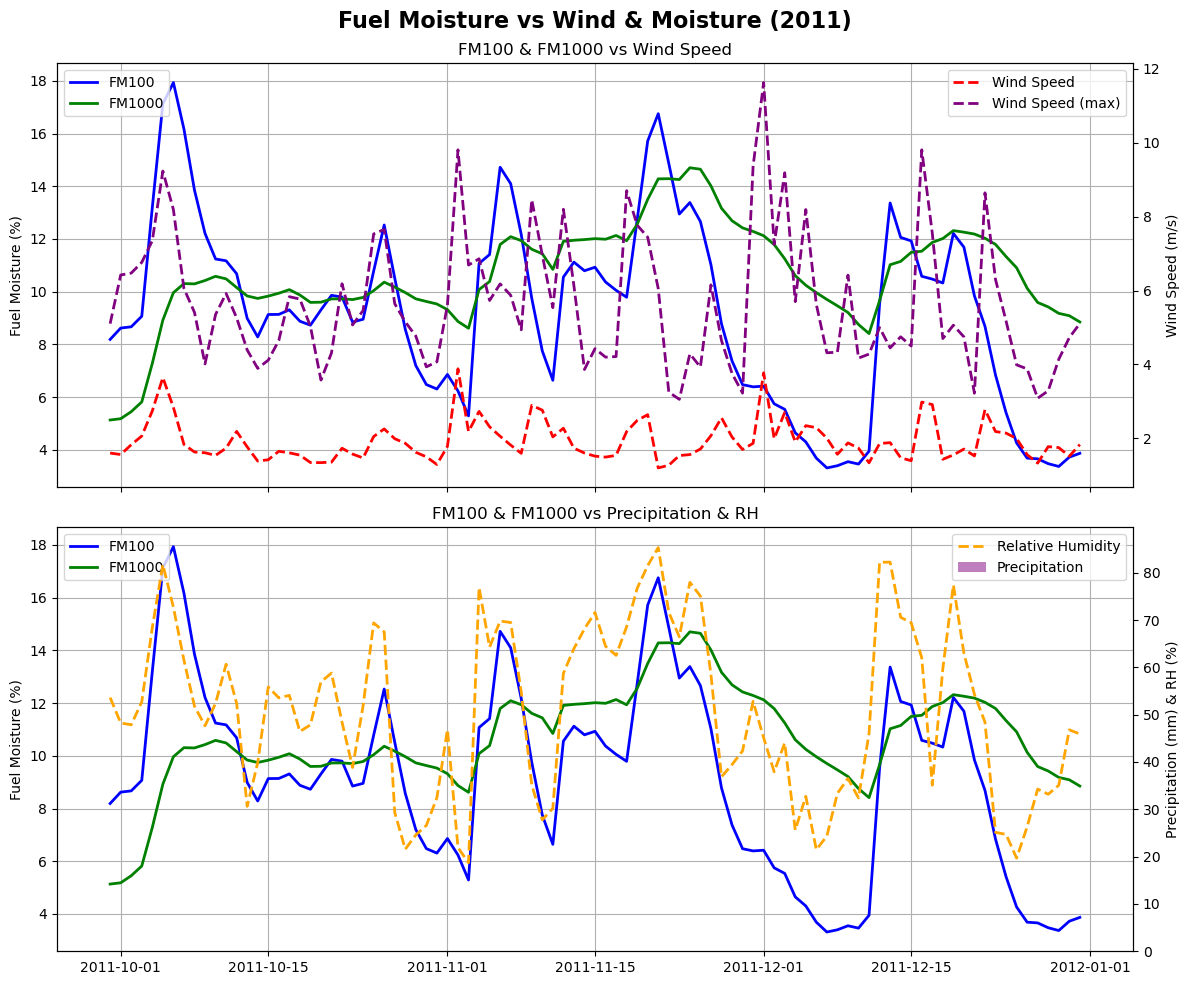

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Select time range
filtered_df = weather_ds.sel(valid_time=slice("2011-09-30", "2011-12-31"))

# Extract variables
time = filtered_df.valid_time
fm100 = filtered_df.fm100.mean(dim=["latitude", "longitude"])
fm1000 = filtered_df.fm1000.mean(dim=["latitude", "longitude"])
wind = filtered_df.wind_mean.mean(dim=["latitude", "longitude"])
wind_max = filtered_df.wind_max.max(dim=["latitude", "longitude"])
precip = filtered_df.precip.mean(dim=["latitude", "longitude"])
rh = filtered_df.rh.mean(dim=["latitude", "longitude"])  # Extract RH directly

# Create figure with 2 subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# **Top Chart: FM100 & FM1000 vs. Wind Speed**
ax1 = axes[0]
ax2 = ax1.twinx()  # Create secondary y-axis

ax1.plot(time, fm100, label="FM100", color="blue", linewidth=2)
ax1.plot(time, fm1000, label="FM1000", color="green", linewidth=2)
ax2.plot(time, wind, label="Wind Speed", color="red", linestyle="dashed", linewidth=2)
ax2.plot(time, wind_max, label="Wind Speed (max)", color="purple", linestyle="dashed", linewidth=2)

ax1.set_ylabel("Fuel Moisture (%)")
ax2.set_ylabel("Wind Speed (m/s)")
ax1.set_title("FM100 & FM1000 vs Wind Speed")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
ax1.grid()

# **Bottom Chart: FM100 & FM1000 vs. Precipitation & RH**
ax3 = axes[1]
ax4 = ax3.twinx()  # Create secondary y-axis

ax3.plot(time, fm100, label="FM100", color="blue", linewidth=2)
ax3.plot(time, fm1000, label="FM1000", color="green", linewidth=2)
ax4.bar(time, precip, label="Precipitation", color="purple", alpha=0.5, width=0.8)
ax4.plot(time, rh, label="Relative Humidity", color="orange", linestyle="dashed", linewidth=2)  # Add RH line

ax3.set_ylabel("Fuel Moisture (%)")
ax4.set_ylabel("Precipitation (mm) & RH (%)")
ax3.set_title("FM100 & FM1000 vs Precipitation & RH")
ax3.legend(loc="upper left")
ax4.legend(loc="upper right")
ax3.grid()

# Adjust layout
plt.suptitle("Fuel Moisture vs Wind & Moisture (2011)", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()
